# Demo of E pooling



In [1]:
import glob
import numpy as np
import h5py
import subprocess
import random
import pdb
import matplotlib.pyplot as plt
import os
import glob
import tensorflow
from keras.layers import Layer, InputSpec
import tensorflow as tf
import keras
from keras import backend as K
import keras.callbacks
from keras import layers
# Helper libraries
import numpy as np

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv1D, MaxPooling1D, Dense, Activation, Dropout, Flatten
from keras.utils import plot_model
from sklearn.metrics import roc_auc_score, auc, roc_curve
from keras import regularizers
from ePooling import *

Using TensorFlow backend.


In [2]:
import tensorflow

In [3]:
print(keras.__version__)
print(tf.__version__)

2.1.6
1.8.0


In [4]:
data_info = 3
local_window_size = 10
epoch_num = 100
valadation_split = 0.1
random_seed = 0
number_of_kernel = 64
kernel_length = 24
patience = 15
ker_len = 24
batch_size = 256
np.random.seed(random_seed)
random.seed(random_seed)
tf.set_random_seed(random_seed)

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"     
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))   

In [6]:
def mkdir(path):
    isExists = os.path.exists(path)
    if not isExists:
        os.makedirs(path)
        return (True)
    else:
        return (False)
    
def load_data(dataset):
    data = h5py.File(dataset, 'r')
    sequence_code = data['sequences'].value
    label = data['labs'].value
    
    return ([sequence_code, label])

In [7]:
data_path = "/rd2/lijy/KDD/vCNNFinal/Data/SimulationOnTwoMotif/HDF5/Simulation"+str(data_info)+"/"
#data_path = "/rd1/tuxm/softpooling/short_long_motif/data/simu_03/"
#data_path = "/rd2/lijy/KDD/vCNNFinal/Data/ChIPSeqData/HDF5/wgEncodeAwgTfbsSydhHelas3MaxIggrabUniPk/"
modelsave_output_prefix = "../../ePooling-temp-data/now"
#data_path = "/home/lijy/VCNNMore/SimuCase/Data/Simu/TwoMotif1/"
test_dataset = data_path + "test.hdf5"
training_dataset = data_path + "train.hdf5"

In [8]:
X_test, Y_test = load_data(test_dataset)
X_train, Y_train = load_data(training_dataset)

In [9]:
print(X_test.shape)
print(Y_test.shape)
input_shape = (X_train.shape[1], 4)

(600, 1000, 4)
(600,)


In [10]:
def relu_advanced(x):
    return K.relu(x, alpha=0.5, max_value=10)


In [11]:
def build_CNN(model_template, number_of_kernel, kernel_length, input_shape,
              pooling="GlobalMax", mode=0, m=1, m_trainable=False, local_window_size= 10):
    """
    :param number_of_kernel: the number of kernels
    :param kernel_length:  kernel length
    :param input_shape:  input shape
    :param pooling:  pooling type GlobalMax or GlobalExpect

    :param mode:  0 or 1, 0 reperezent the option structure 1 (calculate the expectation over the average)
    :param m:   the base to calculate the prob
    :param m_trainable:   True or False
    :param local_window_size:  the local window size of the local max pooling before the GlobalExpect
    :return:  model, optimizer
    """


    model_template.add(Conv1D(
        input_shape=input_shape,
        kernel_size=kernel_length,
        filters=number_of_kernel,
        padding='same',
        strides=1))
    model_template.add(Activation('relu'))

    if pooling == 'GlobalMax':
        model_template.add(keras.layers.GlobalMaxPooling1D())
    elif pooling == 'GlobalAverage':
        model_template.add(keras.layers.GlobalAveragePooling1D())
    else:
        # add the Global Expect pooling 1D
        model_template.add(keras.layers.pooling.MaxPooling1D(pool_length=local_window_size,
                                                             stride=None, border_mode='valid'))
        model_template.add(GlobalExpectationPooling1D(mode = mode, m_trainable = m_trainable, m_value = m))

    model_template.add(keras.layers.core.Dense(output_dim=1, name='Dense_l1'))
    model_template.add(keras.layers.Activation("sigmoid"))
    sgd = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    return model_template, sgd


In [12]:
pooling  = 'GlobalMax'
model_Max = keras.models.Sequential()
model_Max, sgd =  build_CNN(model_Max,
                       number_of_kernel,
                       kernel_length,
                       input_shape = input_shape,
                       pooling = pooling)
model_Max.compile(loss='binary_crossentropy', optimizer=sgd)

/home/tuxm/anaconda3/envs/DL-GPU/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(name="Dense_l1", units=1)`


In [13]:
model_Max.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1000, 64)          6208      
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 64)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________


In [14]:

# set the result path
output_path = modelsave_output_prefix + "/" + str(data_info)
mkdir(output_path)
output_prefix = output_path + "/" \
                            + "model-KernelNum_" + str(number_of_kernel) \
                            + "_random-seed_" + str(random_seed) \
                            + "_batch-size_" + str(batch_size) \
                            + '_kernel-length_' + str(ker_len) \
                            + '_localwindow_'+str(local_window_size) \
                            + '_pooling_'+str(pooling)

modelsave_output_filename = output_prefix + "_checkpointer.hdf5"
history_output_path = output_prefix + '.history'
prediction_save_path = output_prefix + '.npy'

# set the checkpoint and earlystop to save the best model
earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=patience,
                                             verbose=1)

checkpointer = keras.callbacks.ModelCheckpoint(filepath=modelsave_output_filename,
                                               verbose=1,
                                               save_best_only=True)




In [15]:

# train the model, and save the history
history_Max = model_Max.fit(X_train,
                    Y_train,
                    epochs=epoch_num,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=2,
                    callbacks=[checkpointer, earlystopper])

Train on 4860 samples, validate on 540 samples
Epoch 1/100
 - 4s - loss: 0.7892 - val_loss: 0.7342

Epoch 00001: val_loss improved from inf to 0.73416, saving model to ../../ePooling-temp-data/now/3/model-KernelNum_64_random-seed_0_batch-size_256_kernel-length_24_localwindow_10_pooling_GlobalMax_checkpointer.hdf5
Epoch 2/100
 - 4s - loss: 0.6917 - val_loss: 0.7004

Epoch 00002: val_loss improved from 0.73416 to 0.70036, saving model to ../../ePooling-temp-data/now/3/model-KernelNum_64_random-seed_0_batch-size_256_kernel-length_24_localwindow_10_pooling_GlobalMax_checkpointer.hdf5
Epoch 3/100
 - 4s - loss: 0.6807 - val_loss: 0.6953

Epoch 00003: val_loss improved from 0.70036 to 0.69534, saving model to ../../ePooling-temp-data/now/3/model-KernelNum_64_random-seed_0_batch-size_256_kernel-length_24_localwindow_10_pooling_GlobalMax_checkpointer.hdf5
Epoch 4/100
 - 4s - loss: 0.6708 - val_loss: 0.6954

Epoch 00004: val_loss did not improve from 0.69534
Epoch 5/100
 - 4s - loss: 0.6572 - va

In [16]:
# load the best weight
model_Max.load_weights(modelsave_output_filename)

In [17]:
pooling  = 'GlobalAverage'
model_Average = keras.models.Sequential()
model_Average, sgd =  build_CNN(model_Average,
                       number_of_kernel,
                       kernel_length,
                       input_shape = input_shape,
                       pooling = pooling)
model_Average.compile(loss='binary_crossentropy', optimizer=sgd)

/home/tuxm/anaconda3/envs/DL-GPU/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(name="Dense_l1", units=1)`


In [18]:
input_shape = (X_train.shape[1], 4)
# set the result path
output_path = modelsave_output_prefix + "/" + str(data_info)
mkdir(output_path)
output_prefix = output_path + "/" \
                            + "model-KernelNum_" + str(number_of_kernel) \
                            + "_random-seed_" + str(random_seed) \
                            + "_batch-size_" + str(batch_size) \
                            + '_kernel-length_' + str(ker_len) \
                            + '_localwindow_'+str(local_window_size) \
                            + '_pooling_'+str(pooling)

modelsave_output_filename = output_prefix + "_checkpointer.hdf5"
history_output_path = output_prefix + '.history'
prediction_save_path = output_prefix + '.npy'

# set the checkpoint and earlystop to save the best model
earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=patience,
                                             verbose=1)

checkpointer = keras.callbacks.ModelCheckpoint(filepath=modelsave_output_filename,
                                               verbose=1,
                                               save_best_only=True)

In [19]:
# train the model, and save the history
history_Average = model_Average.fit(X_train,
                    Y_train,
                    epochs=epoch_num,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=2,
                    callbacks=[checkpointer, earlystopper])

Train on 4860 samples, validate on 540 samples
Epoch 1/100
 - 3s - loss: 0.7063 - val_loss: 0.6932

Epoch 00001: val_loss improved from inf to 0.69315, saving model to ../../ePooling-temp-data/now/3/model-KernelNum_64_random-seed_0_batch-size_256_kernel-length_24_localwindow_10_pooling_GlobalAverage_checkpointer.hdf5
Epoch 2/100
 - 3s - loss: 0.6932 - val_loss: 0.6932

Epoch 00002: val_loss did not improve from 0.69315
Epoch 3/100
 - 3s - loss: 0.6932 - val_loss: 0.6932

Epoch 00003: val_loss did not improve from 0.69315
Epoch 4/100
 - 3s - loss: 0.6932 - val_loss: 0.6931

Epoch 00004: val_loss improved from 0.69315 to 0.69313, saving model to ../../ePooling-temp-data/now/3/model-KernelNum_64_random-seed_0_batch-size_256_kernel-length_24_localwindow_10_pooling_GlobalAverage_checkpointer.hdf5
Epoch 5/100
 - 3s - loss: 0.6932 - val_loss: 0.6932

Epoch 00005: val_loss did not improve from 0.69313
Epoch 6/100
 - 3s - loss: 0.6932 - val_loss: 0.6932

Epoch 00006: val_loss did not improve fr

In [20]:
# load the best weight
model_Average.load_weights(modelsave_output_filename)

In [21]:
pooling  = 'GlobalExpectation'
model_GlobalExpectation = keras.models.Sequential()
model_GlobalExpectation, sgd =  build_CNN(model_GlobalExpectation,
                       number_of_kernel,
                       kernel_length,
                       input_shape = input_shape,
                       pooling = pooling)
model_GlobalExpectation.compile(loss='binary_crossentropy', optimizer=sgd)

/home/tuxm/anaconda3/envs/DL-GPU/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=10, strides=None, padding="valid")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/home/tuxm/anaconda3/envs/DL-GPU/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(name="Dense_l1", units=1)`


In [22]:
input_shape = (X_train.shape[1], 4)
# set the result path
output_path = modelsave_output_prefix + "/" + str(data_info)
mkdir(output_path)
output_prefix = output_path + "/" \
                            + "model-KernelNum_" + str(number_of_kernel) \
                            + "_random-seed_" + str(random_seed) \
                            + "_batch-size_" + str(batch_size) \
                            + '_kernel-length_' + str(ker_len) \
                            + '_localwindow_'+str(local_window_size) \
                            + '_pooling_'+str(pooling)

modelsave_output_filename = output_prefix + "_checkpointer.hdf5"
history_output_path = output_prefix + '.history'
prediction_save_path = output_prefix + '.npy'

# set the checkpoint and earlystop to save the best model
earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=patience,
                                             verbose=1)

checkpointer = keras.callbacks.ModelCheckpoint(filepath=modelsave_output_filename,
                                               verbose=1,
                                               save_best_only=True)

In [23]:
# train the model, and save the history
history_GlobalExpectation = model_GlobalExpectation.fit(X_train,
                    Y_train,
                    epochs=epoch_num,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=2,
                    callbacks=[checkpointer, earlystopper])

Train on 4860 samples, validate on 540 samples
Epoch 1/100
 - 4s - loss: 0.7410 - val_loss: 0.6986

Epoch 00001: val_loss improved from inf to 0.69858, saving model to ../../ePooling-temp-data/now/3/model-KernelNum_64_random-seed_0_batch-size_256_kernel-length_24_localwindow_10_pooling_GlobalExpectation_checkpointer.hdf5
Epoch 2/100
 - 3s - loss: 0.6951 - val_loss: 0.6959

Epoch 00002: val_loss improved from 0.69858 to 0.69592, saving model to ../../ePooling-temp-data/now/3/model-KernelNum_64_random-seed_0_batch-size_256_kernel-length_24_localwindow_10_pooling_GlobalExpectation_checkpointer.hdf5
Epoch 3/100
 - 3s - loss: 0.6940 - val_loss: 0.6951

Epoch 00003: val_loss improved from 0.69592 to 0.69508, saving model to ../../ePooling-temp-data/now/3/model-KernelNum_64_random-seed_0_batch-size_256_kernel-length_24_localwindow_10_pooling_GlobalExpectation_checkpointer.hdf5
Epoch 4/100
 - 3s - loss: 0.6945 - val_loss: 0.6929

Epoch 00004: val_loss improved from 0.69508 to 0.69289, saving m


Epoch 00038: val_loss did not improve from 0.41826
Epoch 39/100
 - 4s - loss: 0.3838 - val_loss: 0.4205

Epoch 00039: val_loss did not improve from 0.41826
Epoch 40/100
 - 4s - loss: 0.3875 - val_loss: 0.4200

Epoch 00040: val_loss did not improve from 0.41826
Epoch 41/100
 - 4s - loss: 0.3853 - val_loss: 0.4235

Epoch 00041: val_loss did not improve from 0.41826
Epoch 42/100
 - 4s - loss: 0.3830 - val_loss: 0.4246

Epoch 00042: val_loss did not improve from 0.41826
Epoch 43/100
 - 3s - loss: 0.3827 - val_loss: 0.4348

Epoch 00043: val_loss did not improve from 0.41826
Epoch 44/100
 - 3s - loss: 0.3801 - val_loss: 0.4330

Epoch 00044: val_loss did not improve from 0.41826
Epoch 45/100
 - 4s - loss: 0.3774 - val_loss: 0.4245

Epoch 00045: val_loss did not improve from 0.41826
Epoch 46/100
 - 4s - loss: 0.3730 - val_loss: 0.4236

Epoch 00046: val_loss did not improve from 0.41826
Epoch 47/100
 - 4s - loss: 0.3739 - val_loss: 0.4237

Epoch 00047: val_loss did not improve from 0.41826
Epo

In [24]:
# load the best weight
model_GlobalExpectation.load_weights(modelsave_output_filename)

In [25]:
# prediction = model_Max.predict(X_test)
# roc_auc_score(Y_test, prediction)
# false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, prediction)
# roc_auc = auc(false_positive_rate, true_positive_rate)

# plt.title('Receiver Operating Characteristic')
# plt.plot(false_positive_rate, true_positive_rate, 'b',
# label='AUC = %0.5f'% roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1])
# plt.ylim([-0.1,1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# #plt.savefig("AUC_l1_l2_data"+str(data_info)+'AUC'+str(roc_auc).replace(".", "_")+'.eps', format='eps', dpi=1000)
# plt.show()

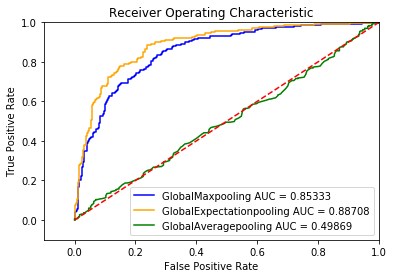

In [26]:
prediction = model_Max.predict(X_test)
roc_auc_score(Y_test, prediction)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='GlobalMaxpooling AUC = %0.5f'% roc_auc)

prediction = model_GlobalExpectation.predict(X_test)
roc_auc_score(Y_test, prediction)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, 'orange',
label='GlobalExpectationpooling AUC = %0.5f'% roc_auc)

prediction = model_Average.predict(X_test)
roc_auc_score(Y_test, prediction)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, 'green',
label='GlobalAveragepooling AUC = %0.5f'% roc_auc)


plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(str(data_info)+'AUC.eps',
               format='eps', dpi=1000)
plt.show()